In [2]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

from hmg import HBV1D012A


In [3]:
def NSE(sim_dis, obs_dis):
    # obs are the "true" values, sim is our model output
    mean_obs_dis = np.mean(obs_dis)
    return 1 - (np.sum([(obs_dis[i] - sim_dis[i])**2 for i in range(len(sim_dis))])) / (np.sum([(obs_dis[i] - mean_obs_dis)**2 for i in range(len(sim_dis))]))

def LnNSE(sim_dis, obs_dis):
    #! how to penalize log(0)?
    #! - penalty * (2 + np.random.random())
    raise ValueError("Not implemented yet")

def KGE(sim_dis, obs_dis):
    raise ValueError("Not implemented yet")


def objective_function(prms, diso, modl_objt, efficieny_metric, parameter_in_optimization, obj_values):

    allowed_metrics = {NSE, LnNSE, KGE}
    if efficieny_metric not in allowed_metrics:
        raise ValueError(f"efficieny_metric must be one of {allowed_metrics}")

    modl_objt.set_parameters(prms)
    modl_objt.set_optimization_flag(0)

    # Run the model for the given inputs, constants and parameters.
    modl_objt.run_model()
    diss = modl_objt.get_discharge()

    # NSE calculation
    efficiency_value = efficieny_metric(sim_dis=diss, obs_dis=diso)
    # print(f"NSE: {NSE_value}")

    OBJ_value = 1 - efficiency_value
    # print(f"OBJ: {OBJ_value}")

    parameter_in_optimization.append(prms.copy())
    obj_values.append(OBJ_value)
    return OBJ_value

def setup_object_with_data():
    main_dir = Path(r'/Users/elias/Desktop/HWS24/MMUQ Seminar/time_series__24163005')
    os.chdir(main_dir)
    inp_dfe = pd.read_csv(r'time_series___24163005.csv', sep=';', index_col=0)
    inp_dfe.index = pd.to_datetime(inp_dfe.index, format='%Y-%m-%d-%H')
    cca_srs = pd.read_csv(r'area___24163005.csv', sep=';', index_col=0)
    ccaa = cca_srs.values[0, 0]
    tems = inp_dfe.loc[:, 'tavg__ref'].values  # Temperature.
    ppts = inp_dfe.loc[:, 'pptn__ref'].values  # Preciptiation.
    pets = inp_dfe.loc[:, 'petn__ref'].values  # PET.
    modl_objt = HBV1D012A()
    tsps = tems.shape[0]  # Number of time steps.
    dslr = ccaa / (3600 * 1000)  # For daily res. multiply denominator with 24.
    modl_objt.set_inputs(tems, ppts, pets)
    modl_objt.set_outputs(tsps)
    modl_objt.set_discharge_scaler(dslr)
    return modl_objt

def get_diso():
    main_dir = Path(r'/Users/elias/Desktop/HWS24/MMUQ Seminar/time_series__24163005')
    os.chdir(main_dir)
    inp_dfe = pd.read_csv(r'time_series___24163005.csv', sep=';', index_col=0)
    inp_dfe.index = pd.to_datetime(inp_dfe.index, format='%Y-%m-%d-%H')
    diso = inp_dfe.loc[:, 'diso__ref'].values  # Observed discharge.
    return diso

In [4]:
bounds = {
    # Snow.
    'snw_dth': (0.0, 0.0), #! on if upper bound 100 # Initial depth [L].
    'snw_ast': (-1.0, 1.0), #! off if -999 # Air snow TEM [K].
    'snw_amt': (0.0, 2.0), #! off if -99 # Air melt TEM [K].
    'snw_amf': (0.0, 2.0), #! off if 0 # Air melt factor [L/TK].
    'snw_pmf': (0.0, 2.0), #! off if 0 # PPT melt factor [L/LTK].

    # Soils.
    'sl0_mse': (0.0, 1e+2), # Soil 0 initial depth [L].
    'sl1_mse': (0.0, 2e+2), # Soil 1 initial depth [L].

    # Soil 0.
    'sl0_fcy': (0.0, 2e+2), #! off if 0 # Field capacity [L].
    'sl0_bt0': (0.0, 3.0), #! off if 0 # Beta [-].

    # Soil 1.
    'sl1_pwp': (0.0, 4e+2), #! if Soil 0 off Soil 1 has to be off as well # PWP [L].
    'sl1_fcy': (0.0, 4e+2), # Field capacity [L].
    'sl1_bt0': (0.0, 4.0), # Beta [-].

    # Routing reservoirs.
    'urr_dth': (0.0, 2e+1), # URR initial depth [L].
    'lrr_dth': (0.0, 5.0), # LRR initial depth [L].

    # Upper reservoir.
    'urr_rsr': (0.0, 1.0), # Runoff split ratio [-].
    'urr_tdh': (0.0, 1e+2), # Threshold depth [L].
    'urr_tdr': (0.0, 1.0), # Threshold DIS const. [1/T].
    'urr_cst': (0.0, 1.0), # RNF const. [1/T].
    'urr_dro': (0.0, 1.0), # DIS ratio [-].
    'urr_ulc': (0.0, 1.0), # URR-to-LRR const. [1/T].

    # Lower reservoir.
    'lrr_tdh': (0.0, 1e+4), # Threshold depth [L].
    'lrr_cst': (0.0, 1.0), # Runoff const. [1/T].
    'lrr_dro': (0.0, 1.0) # Discharge ratio [-].
}


prms = np.array([
    0.00,  # 'snw_dth'
    -0.1,  # 'snw_ast'
    +0.1,  # 'snw_amt'
    0.01,  # 'snw_amf'
    0.00,  # 'snw_pmf'

    50.0,  # 'sl0_mse'
    300.,  # 'sl1_mse'

    70.0,  # 'sl0_fcy'
    2.50,  # 'sl0_bt0'

    300.,  # 'sl1_pwp'
    400.,  # 'sl1_fcy'
    2.50,  # 'sl1_bt0'

    0.00,  # 'urr_dth'
    0.00,  # 'lrr_dth'

    1.00,  # 'urr_rsr'
    30.0,  # 'urr_tdh'
    0.15,  # 'urr_tdr'
    1e-4,  # 'urr_cst'
    1.00,  # 'urr_dro'
    0.00,  # 'urr_ulc'

    0.00,  # 'lrr_tdh'
    0.00,  # 'lrr_cst'
    0.00,  # 'lrr_dro'
    ], dtype=np.float32)

In [5]:
diso = get_diso()
modl_objt = setup_object_with_data()
#! objective_function(prms, diso, modl_objt, NSE, parameter_in_optimization, obj_values)

In [6]:
# parameter_in_optimization = []
# obj_values = []

# result = differential_evolution(objective_function, list(bounds.values()), polish=False, args=(diso, modl_objt, NSE, parameter_in_optimization, obj_values))

# parameter_in_optimization = np.array(parameter_in_optimization)
# obj_values = np.array(obj_values)

# print(f"result.x: {result.x}")
# print(f"result.fun: {result.fun}")

# opt_prms = result.x

In [7]:
# result from above
opt_prms = np.array([0.00000000e+00, # 'snw_dth'
            -5.40842277e-01, # 'snw_ast'
            1.35096768e+00, # 'snw_amt'
            2.80866510e-01, # 'snw_amf'
            2.00923615e-01, # 'snw_pmf'

            6.91879331e+01, # 'sl0_mse'
            1.38003305e+02, # 'sl1_mse'

            1.37022235e+02, # 'sl0_fcy'
            2.29294957e+00, # 'sl0_bt0'

            1.29946812e+02, # 'sl1_pwp'
            1.99637692e+00, # 'sl1_fcy'
            5.62062007e-01, # 'sl1_bt0'

            1.22027092e+00, # 'urr_dth'
            8.49411993e-01, # 'lrr_dth'

            9.21348249e-01, # 'urr_rsr'
            5.62557583e+01, # 'urr_tdh'
            7.38652276e-01, # 'urr_tdr'
            1.83267567e-04, # 'urr_cst'
            5.35001747e-01, # 'urr_dro'
            1.74634941e-01, # 'urr_ulc'

            4.83906619e+03, # 'lrr_tdh'
            9.78105483e-03, # 'lrr_cst'
            9.98485024e-01 # 'lrr_dro'
            ], dtype=np.float32)

In [8]:
# Function to vary one of the parameters in the bounds and fix the rest to the optimal values
def vary_one_parameter(param_name, bounds, opt_prms, diso, modl_objt, sample_size, rel_difference):
    opt_prms_copy = opt_prms.copy()
    param_index = list(bounds.keys()).index(param_name)
    # use boundaries +- 20%
    opt_param_value = opt_prms_copy[param_index]
    if opt_param_value == 0:
        #! raise ValueError("Optimal parameter value is 0")
        print("For the parameter: ", param_name, " the optimal value is 0")
        return None, None
    elif opt_param_value < 0:
        upper_bound = np.min([bounds[param_name][1], opt_param_value * (1 - rel_difference)])
        lower_bound = np.max([bounds[param_name][0], opt_param_value * (1 + rel_difference)])
    else:
        upper_bound = np.min([bounds[param_name][1], opt_param_value * (1 + rel_difference)])
        lower_bound = np.max([bounds[param_name][0], opt_param_value * (1 - rel_difference)])
    param_values = np.linspace(lower_bound, upper_bound, sample_size)
    obj_func_values = []
    for param_value in param_values:
        opt_prms_copy[param_index] = param_value
        obj_func_values.append(objective_function(opt_prms_copy, diso, modl_objt, NSE, [], []))
    return param_values, obj_func_values

Model runtime: 3.44E-02 seconds.
For the parameter:  snw_dth  the optimal value is 0
Model runtime: 3.50E-02 seconds.
Model runtime: 3.29E-02 seconds.
Model runtime: 3.38E-02 seconds.
Model runtime: 3.28E-02 seconds.
Model runtime: 3.34E-02 seconds.
Model runtime: 5.14E-02 seconds.
Model runtime: 7.35E-02 seconds.
Model runtime: 3.31E-02 seconds.
Model runtime: 3.61E-02 seconds.
Model runtime: 2.98E-02 seconds.
Model runtime: 3.32E-02 seconds.
Model runtime: 3.38E-02 seconds.
Model runtime: 4.10E-02 seconds.
Model runtime: 3.20E-02 seconds.
Model runtime: 3.62E-02 seconds.
Model runtime: 3.34E-02 seconds.
Model runtime: 3.15E-02 seconds.
Model runtime: 3.70E-02 seconds.
Model runtime: 3.75E-02 seconds.
Model runtime: 3.65E-02 seconds.
Model runtime: 3.92E-02 seconds.
Model runtime: 4.20E-02 seconds.
Model runtime: 3.33E-02 seconds.
Model runtime: 3.72E-02 seconds.
Model runtime: 4.09E-02 seconds.
Model runtime: 3.55E-02 seconds.
Model runtime: 3.25E-02 seconds.
Model runtime: 3.32E-02 

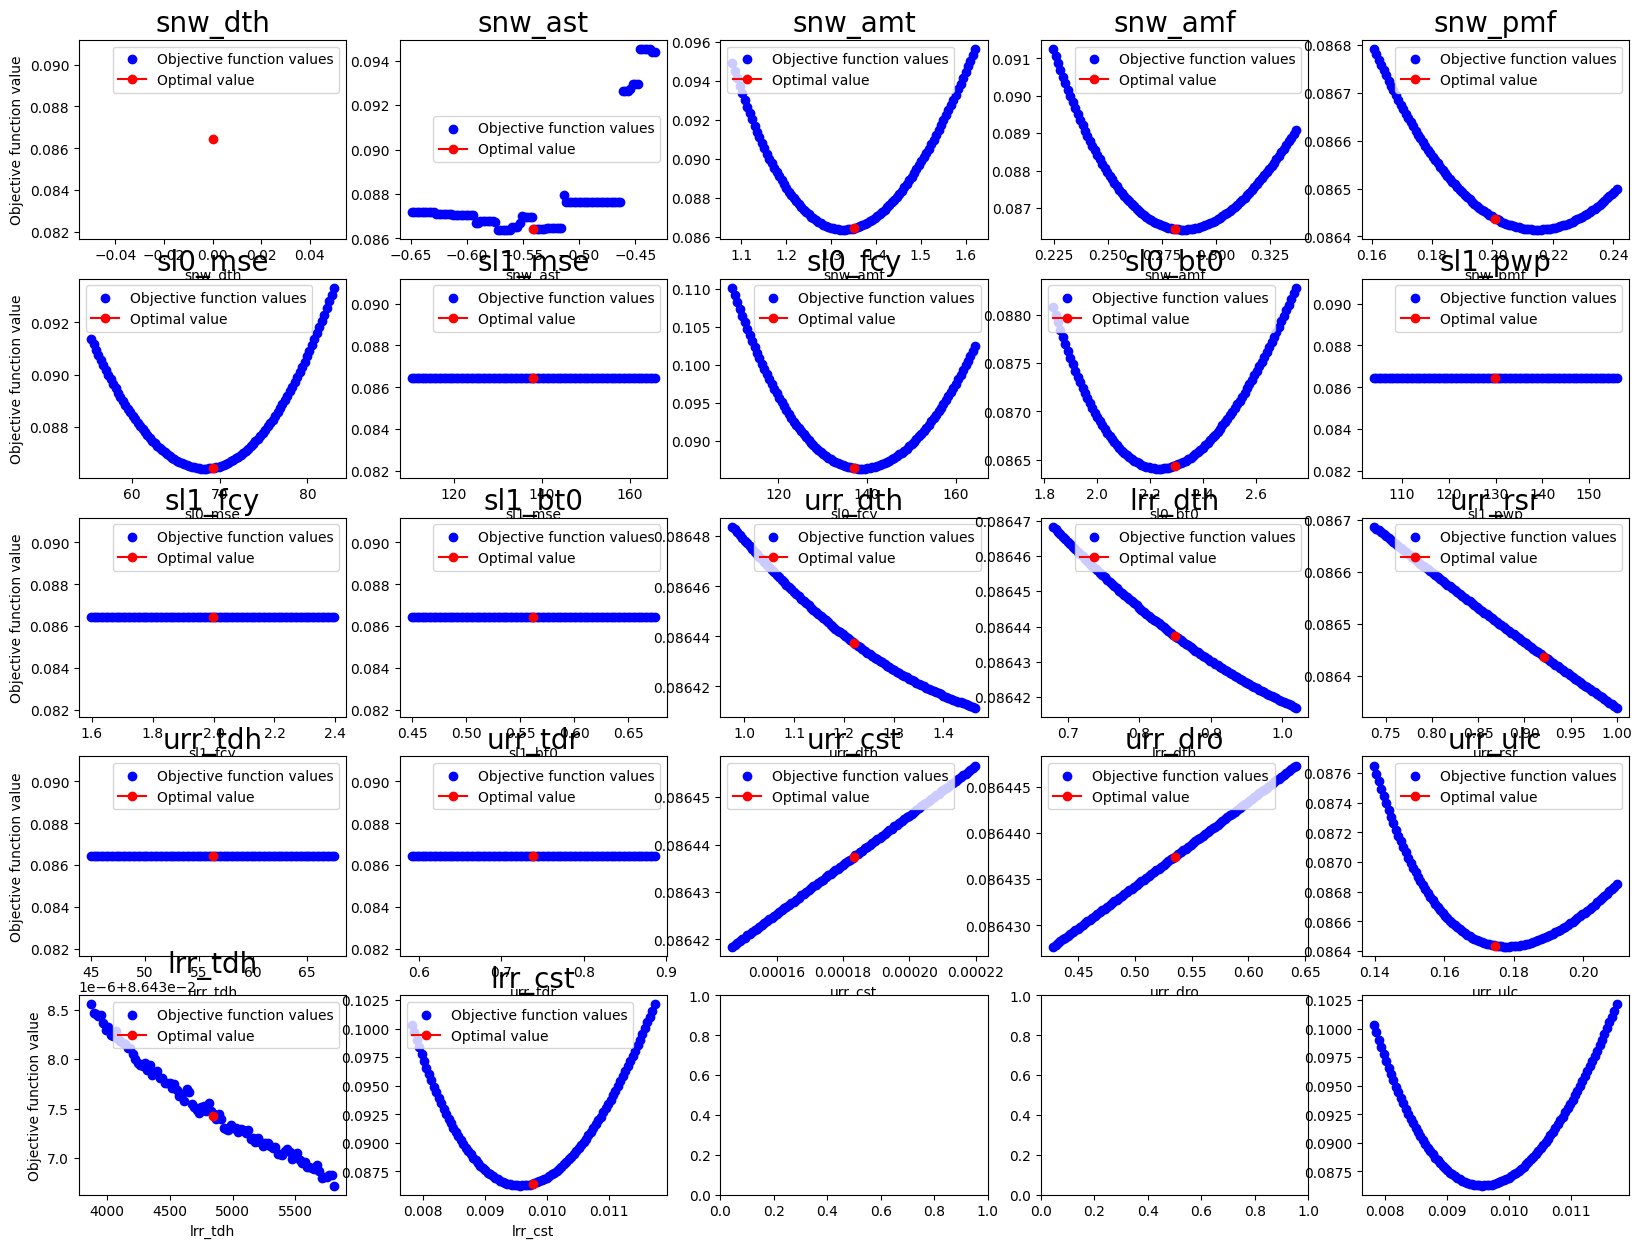

Model runtime: 2.16E-02 seconds.
Model runtime: 1.88E-02 seconds.
Model runtime: 1.90E-02 seconds.
Model runtime: 1.85E-02 seconds.
Model runtime: 2.07E-02 seconds.
Model runtime: 1.87E-02 seconds.
Model runtime: 1.92E-02 seconds.
Model runtime: 1.91E-02 seconds.
Model runtime: 1.89E-02 seconds.
Model runtime: 1.88E-02 seconds.
Model runtime: 1.96E-02 seconds.
Model runtime: 2.21E-02 seconds.
Model runtime: 2.23E-02 seconds.
Model runtime: 2.43E-02 seconds.
Model runtime: 2.25E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.23E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.35E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.20E-02 seconds.
Model runtime: 2.33E-02 seconds.
Model runtime: 2.23E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.38E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.70E-02 seconds.
Model runtime: 3.15E-02 seconds.
Model runtime: 3.14E-02 seconds.
Model runtime: 3.11E-02 seconds.
Model runt

<Figure size 640x480 with 0 Axes>

In [ ]:
# Cell takes 1 minute
# Relative difference 0.2

sample_size = 100
rel_difference = 0.2

diso = get_diso()
modl_objt = setup_object_with_data()

fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for index, param_name in enumerate(bounds.keys()):
    param_value_opt = opt_prms[list(bounds.keys()).index(param_name)]
    obj_func_value_opt = objective_function(opt_prms, diso, modl_objt, NSE, [], [])
    param_values, obj_func_values = vary_one_parameter(param_name, bounds, opt_prms, diso, modl_objt, sample_size, rel_difference)
    axs[index // 5, index % 5].scatter(param_values, obj_func_values, color='blue', label="Objective function values")
    axs[index // 5, index % 5].plot(param_value_opt, obj_func_value_opt, label='Optimal value', color='red', marker='o')
    axs[index // 5, index % 5].set_xlabel(param_name)
    axs[index // 5, index % 5].legend()
    axs[index // 5, index % 5].set_title(f'{param_name}', fontsize = 20)

    if index % 5 == 0:
        axs[index // 5, index % 5].set_ylabel('Objective function value')

plt.tight_layout()
plt.show()

Model runtime: 2.18E-02 seconds.
For the parameter:  snw_dth  the optimal value is 0
Model runtime: 2.18E-02 seconds.
Model runtime: 2.18E-02 seconds.
Model runtime: 2.17E-02 seconds.
Model runtime: 2.14E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.20E-02 seconds.
Model runtime: 2.14E-02 seconds.
Model runtime: 2.18E-02 seconds.
Model runtime: 2.17E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.36E-02 seconds.
Model runtime: 2.34E-02 seconds.
Model runtime: 2.31E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.32E-02 seconds.
Model runtime: 2.24E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.37E-02 seconds.
Model runtime: 2.58E-02 seconds.
Model runtime: 2.69E-02 seconds.
Model runtime: 2.67E-02 seconds.
Model runtime: 2.63E-02 seconds.
Model runtime: 2.67E-02 seconds.
Model runtime: 2.83E-02 seconds.
Model runtime: 3.26E-02 seconds.
Model runtime: 2.92E-02 

KeyboardInterrupt: 

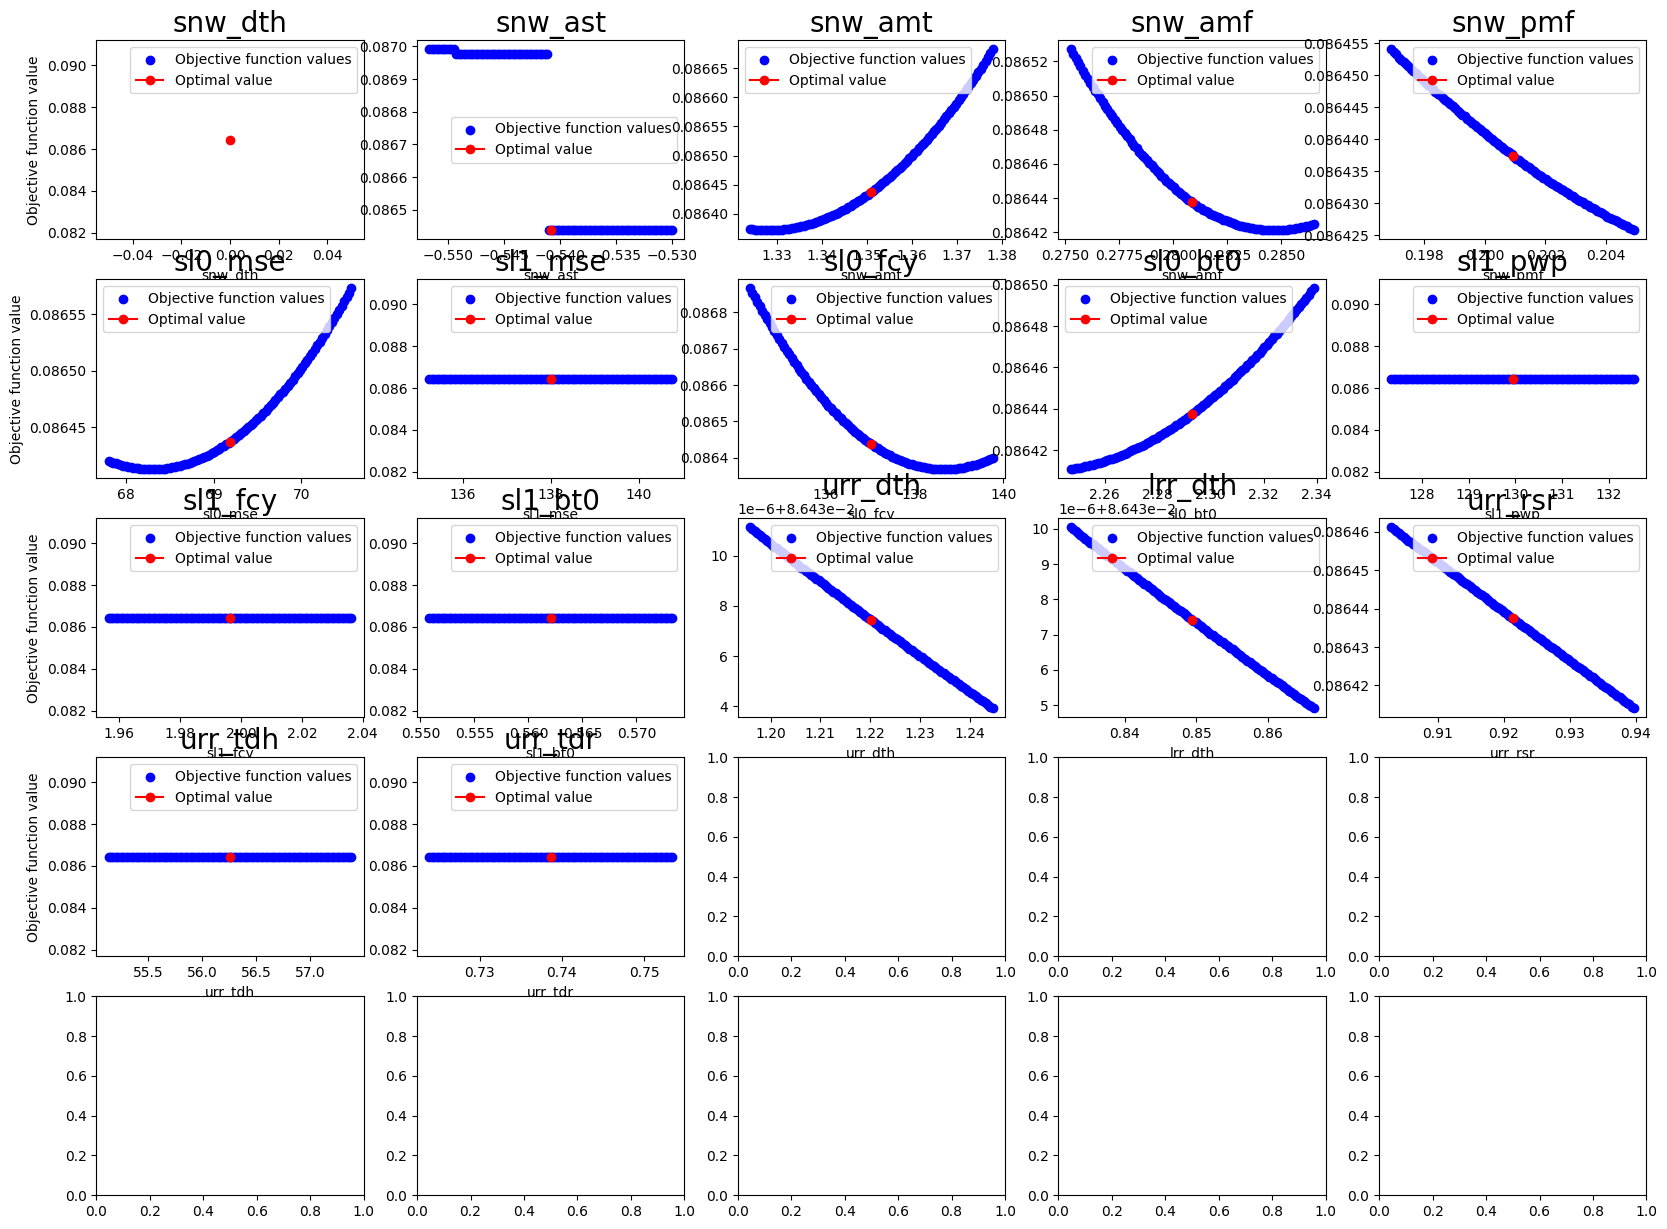

In [10]:
# Cell takes 1 minute
# Relative difference 0.02

sample_size = 100
rel_difference = 0.02

diso = get_diso()
modl_objt = setup_object_with_data()

fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for index, param_name in enumerate(bounds.keys()):
    param_value_opt = opt_prms[list(bounds.keys()).index(param_name)]
    obj_func_value_opt = objective_function(opt_prms, diso, modl_objt, NSE, [], [])
    param_values, obj_func_values = vary_one_parameter(param_name, bounds, opt_prms, diso, modl_objt, sample_size, rel_difference)
    axs[index // 5, index % 5].scatter(param_values, obj_func_values, color='blue', label="Objective function values")
    axs[index // 5, index % 5].plot(param_value_opt, obj_func_value_opt, label='Optimal value', color='red', marker='o')
    axs[index // 5, index % 5].set_xlabel(param_name)
    axs[index // 5, index % 5].legend()
    axs[index // 5, index % 5].set_title(f'{param_name}', fontsize = 20)

    if index % 5 == 0:
        axs[index // 5, index % 5].set_ylabel('Objective function value')

plt.tight_layout()
plt.show()

Model runtime: 2.30E-02 seconds.
For the parameter:  snw_dth  the optimal value is 0
Model runtime: 2.30E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.21E-02 seconds.
Model runtime: 2.21E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.23E-02 seconds.
Model runtime: 2.25E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.41E-02 seconds.
Model runtime: 2.39E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.35E-02 seconds.
Model runtime: 2.36E-02 seconds.
Model runtime: 2.32E-02 seconds.
Model runtime: 2.33E-02 seconds.
Model runtime: 2.26E-02 seconds.
Model runtime: 2.34E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.25E-02 seconds.
Model runtime: 2.23E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 

/Users/elias/miniconda3/envs/mmuq/lib/python3.11/site-packages/hmg/models/hbv1d012a_py.py:429: RuntimeWarning: divide by zero encountered in scalar divide
  lpv_sl0_ror = powf(lpv_sl0_mse / prm_sl0_fcy, prm_sl0_bt0)


Model runtime: 2.30E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.31E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.21E-02 seconds.
Model runtime: 2.21E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.31E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.32E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.31E-02 seconds.
Model runt

/Users/elias/miniconda3/envs/mmuq/lib/python3.11/site-packages/hmg/models/hbv1d012a_py.py:447: RuntimeWarning: divide by zero encountered in scalar divide
  lpv_sl1_epr = lpv_sl1_mse / prm_sl1_pwp


Model runtime: 2.30E-02 seconds.
Model runtime: 2.24E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.31E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.32E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.31E-02 seconds.
Model runtime: 2.28E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.30E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.29E-02 seconds.
Model runtime: 2.27E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.22E-02 seconds.
Model runtime: 2.20E-02 seconds.
Model runtime: 2.20E-02 seconds.
Model runtime: 2.20E-02 seconds.
Model runtime: 2.19E-02 seconds.
Model runt

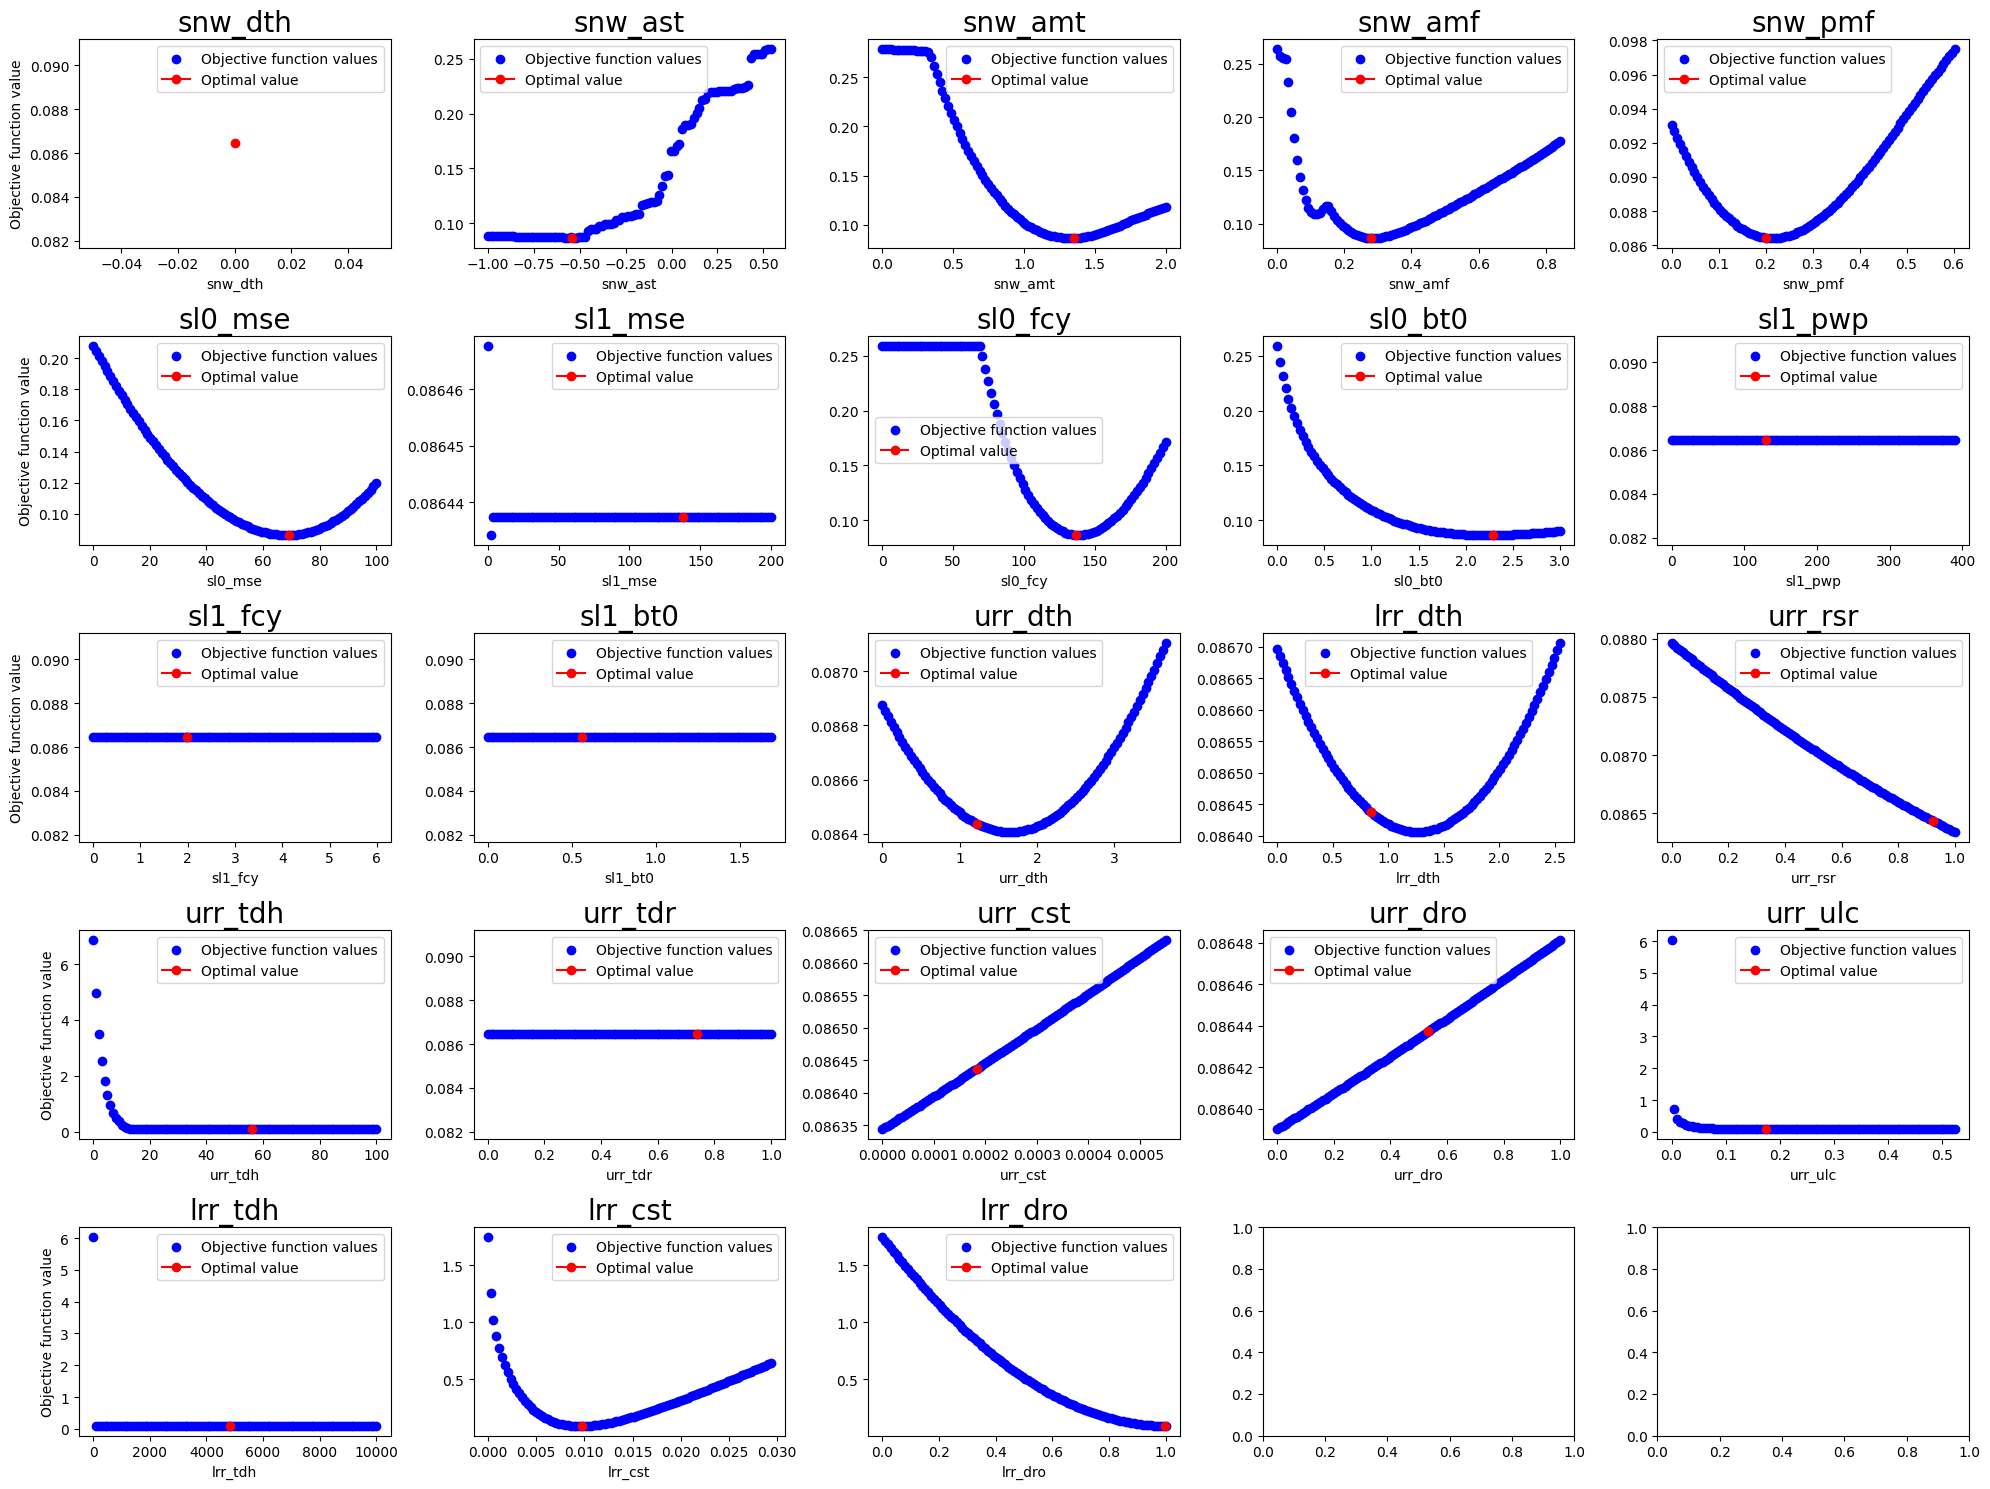

In [ ]:
# Cell takes 1 minute
# Relative difference 2

sample_size = 100
rel_difference = 2

diso = get_diso()
modl_objt = setup_object_with_data()

fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for index, param_name in enumerate(bounds.keys()):
    param_value_opt = opt_prms[list(bounds.keys()).index(param_name)]
    obj_func_value_opt = objective_function(opt_prms, diso, modl_objt, NSE, [], [])
    param_values, obj_func_values = vary_one_parameter(param_name, bounds, opt_prms, diso, modl_objt, sample_size, rel_difference)
    axs[index // 5, index % 5].scatter(param_values, obj_func_values, color='blue', label="Objective function values")
    axs[index // 5, index % 5].plot(param_value_opt, obj_func_value_opt, label='Optimal value', color='red', marker='o')
    axs[index // 5, index % 5].set_xlabel(param_name)
    axs[index // 5, index % 5].legend()
    axs[index // 5, index % 5].set_title(f'{param_name}', fontsize = 20)

    if index % 5 == 0:
        axs[index // 5, index % 5].set_ylabel('Objective function value')

plt.tight_layout()
plt.show()

In [ ]:
# Cell takes 1 minute

# How to rank parameters by sensitivity?
# We use mean squared error
def MSE(obj_func_value_opt, obj_func_values):
    return np.mean((obj_func_value_opt - obj_func_values)**2)

sample_size = 100

diso = get_diso()
modl_objt = setup_object_with_data()

mse_map = {}
for index, param_name in enumerate(bounds.keys()):
    param_value_opt = opt_prms[list(bounds.keys()).index(param_name)]
    obj_func_value_opt = objective_function(opt_prms, diso, modl_objt, NSE, [], [])
    param_values, obj_func_values = vary_one_parameter(param_name, bounds, opt_prms, diso, modl_objt, sample_size)
    if param_values is not None:
        mse_map[param_name] = MSE(obj_func_value_opt, obj_func_values)

mse_map = dict(sorted(mse_map.items(), key=lambda item: item[1], reverse= True))
for key, value in mse_map.items():
    print(f"{key}: {value}")

Model runtime: 3.72E-02 seconds.
For the parameter:  snw_dth  the optimal value is 0
Model runtime: 3.50E-02 seconds.
Model runtime: 4.36E-02 seconds.
Model runtime: 4.76E-02 seconds.
Model runtime: 4.33E-02 seconds.
Model runtime: 3.31E-02 seconds.
Model runtime: 3.98E-02 seconds.
Model runtime: 3.76E-02 seconds.
Model runtime: 3.52E-02 seconds.
Model runtime: 3.92E-02 seconds.
Model runtime: 3.37E-02 seconds.
Model runtime: 3.77E-02 seconds.
Model runtime: 4.25E-02 seconds.
Model runtime: 3.52E-02 seconds.
Model runtime: 4.33E-02 seconds.
Model runtime: 3.85E-02 seconds.
Model runtime: 5.09E-02 seconds.
Model runtime: 5.06E-02 seconds.
Model runtime: 3.71E-02 seconds.
Model runtime: 4.80E-02 seconds.
Model runtime: 4.29E-02 seconds.
Model runtime: 3.88E-02 seconds.
Model runtime: 3.62E-02 seconds.
Model runtime: 3.70E-02 seconds.
Model runtime: 3.36E-02 seconds.
Model runtime: 3.54E-02 seconds.
Model runtime: 3.60E-02 seconds.
Model runtime: 4.47E-02 seconds.
Model runtime: 4.33E-02 